In [1]:
import numpy as np
import math
import scipy.stats
import matplotlib.pyplot as plt
import glob
import os
import re

plt.style.use('dark_background')

In [2]:
def expfit(D, x = None):
    S = [0]
    n = D.shape[0]
    if type(x) is np.ndarray:
        x = x.copy()
        x -= x[0]
    else:
        x = np.arange(n)
        
    for k in range(1, n):
        S.append(S[-1] + (D[k] + D[k - 1]) * (x[k] - x[k - 1]) / 2)

    S = np.array(S)

    A = [[np.sum(x ** 2), np.sum(x * S)],
        [np.sum(x * S), np.sum(S ** 2)]]
    B = [np.sum((D - D[0]) * x), np.sum((D - D[0]) * S)]
    [_, c] = np.linalg.solve(A, B)
    C = [[n, np.sum(np.exp(c * x))],
        [np.sum(np.exp(c * x)), np.sum(np.exp(2 * c * x))]]
    D_ = [np.sum(D), np.sum(D * np.exp(c * x))]
    [a, b] = np.linalg.solve(C, D_)
    
    return (a, b, c)

In [3]:
# alpha = -((amax / vmax) + b/m)
# beta = amax - F0 / m
# system: a = (1 - v / vmax) * amax - b' * v - F0'
# => a = -((amax / vmax) + b')*v + (amax - F0')
# => a = alpha * v + beta
# => v = k1*exp(alpha * t) - beta / alpha
# => v = B * exp(C * t) + A
# => 
# A -> -beta / alpha
# B -> ~= beta/alpha (due to v=0 @t=0)
# C -> alpha

85.95890727807044 0.001033514698084345
111.0224407750329 0.0011785662702774233
157.50349950107812 0.0012928450383908375
220.64141376799128 0.0013792189248145901
291.27772602048583 0.0014486355511431038
326.12845806281877 0.001551621858224446
389.26126541104645 0.0016157572662985381
476.4058739530107 0.0016470864206841035
526.5019501526482 0.0017155740601416335
65.20881989411491 0.0010536473893438714
120.87088249536723 0.0011682108926798374
170.61337799837514 0.0012783662688092715
209.42307067727992 0.0013920122569999166
253.4563912371622 0.0014923461505240128
330.5047841574597 0.0015465182289041929
381.697510933383 0.001624602321863216
485.5477325504892 0.0016369504749815247
533.251970240375 0.0017080213815260476


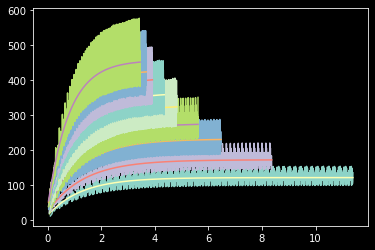

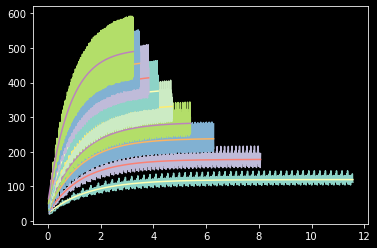

In [19]:
D = {}
SKIP = 1
TICK2RADS = 1E6 / 42 * math.pi * 2
V0 = 858 * 0.00893

TIME_DOWNSAMPLING = 8

B = 1.5498
F0 = 1000 # 198.81 * B

for d in sorted(os.listdir('.')):
    if os.path.isdir(d) and d[0] != '.':
        plt.figure()
        D[d] = {}
        for fn in sorted(os.listdir(d)):
            duty = int(fn)
            D_ = []
            with open('%s/%s' % (d, fn), 'r') as f:
                f.__next__()
                for l in f:
                    D_ += [int(a) for a in re.sub(r'[{}]', '', l.strip()).split(',')]
            D_ = np.array(D_)[SKIP:]
            X = np.cumsum(D_) * 1E-6 * TIME_DOWNSAMPLING
            V = TICK2RADS / D_
            volt = duty / 2048 * V0
            
            t = expfit(V, X)
            D[d][duty] = t
            (a, b, c) = t
            
            tau0 = b * c
            Ki = volt / (tau0 + F0)
            Kv = (volt - Ki * (B * a + F0)) / a
            
            print(tau0, Ki)
            
            v_dyn = b * np.exp(c * X) + a
            tau_dyn = b * c * np.exp(c * X)
            volt_tau_dyn = volt - (Kv * v_dyn + Ki * (B * v_dyn + F0))
            if False:
                plt.plot(X, tau_dyn / volt_tau_dyn)
            
            if True:
                alpha = c
                beta = -a * c
                amax = beta + F0
                vmax = -amax / (alpha + B)

                vtheory = b * np.exp(c * X) + a
                atheory = (1 - V / vmax) * amax - F0 - B * V
                areal = (b * c * np.exp(c * X))

#                 plt.semilogy(X, areal / atheory)
#                 plt.grid(True)
                plt.plot(X, V)
                plt.plot(X, a + b * np.exp(c * X))
#                 plt.plot(X, )

0.0032747243892778007 -284.03178175537033


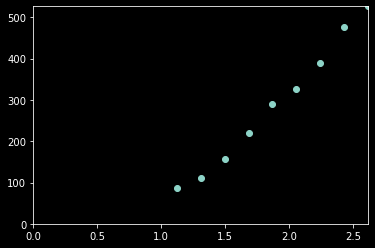

In [21]:
T0s = []
Vfs = []
Vs = []
for duty, (a, b, c) in D['bkwd'].items():
    V = V0 * duty / 2048
    # Ki.append(-a * c / V)
    T0s.append(b * c)
    Vfs.append(a)
    Vs.append(V)

Ki, F0 = np.polyfit(Vs, T0s, 1)
plt.scatter(alphas, T0s)
plt.xlim([0, np.amax(Vs)])
plt.ylim([0, np.amax(T0s)])
print(1 / Ki, F0)

B: -0.387; F0: 77.031


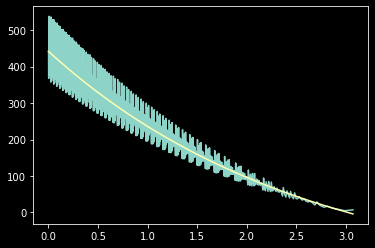

In [9]:
D_ = []
TIME_DOWNSAMPLING = 4
with open('slowdown', 'r') as f:
    f.__next__()
    for l in f:
        D_ += [int(a) for a in re.sub(r'[{}]', '', l.strip()).split(',')]
D_ = np.array(D_)
X = np.cumsum(D_) * 1E-6 * TIME_DOWNSAMPLING
V = TICK2RADS / D_
t = expfit(V, X)
(a, b, c) = t
plt.plot(X, V)
plt.plot(X, a + b * np.exp(c * X))
print('B: %.3f; F0: %.3f' % (c, a * c))